In [5]:
import numpy as np
import pickle
import os
import datetime
from itertools import chain
import matplotlib.pyplot as plt
from lpsd import lpsd
import pandas as pd
import math

In [12]:
save_dir = r"N:\SCI-NBI-Other\membrane\Users\Leo\membrane_square_low_stress\interferometer_characterization\time_series_MFLI_2605"

data_MFLI = {'f_d':[], 't':[]}  # MFLI output drive freq + timestamp
num_measurements = 60 # 60 measurements for 1s each give 60 .dat files
timebase_MFLI = 1.66667E-8 # TODO: rework
ij = 1

for ii in range(num_measurements):
    fp = os.path.join(save_dir, "%s.dat" % ij)
    file=open(fp,'rb')
    data_i_poll = pickle.load(file)
    
    data_MFLI['t'].append(data_i_poll['timestamp'])
    data_MFLI['f_d'].append(data_i_poll['frequency'])
    file.close()
    ij=ij+1

data_MFLI_t = np.array(list(chain.from_iterable(data_MFLI['t'])))  # flatten into np array
data_MFLI_fd = np.array(list(chain.from_iterable(data_MFLI['f_d'])))

data_MFLI_t = (data_MFLI_t - data_MFLI_t[0]) * timebase_MFLI # convert to seconds

In [7]:
# decorator to check if attributes are loaded
def requires_attrs(*attrs):  # extra wrapper needed to pass arguments to decorator
    def decorator(func):
        def wrapper(self, *args, **kwargs):  # args, kwargs are arguments to be passed to method
            for attr in attrs:
                if getattr(self, attr, None) is None:
                    raise ValueError(f"Attribute '{attr}' must be set before calling '{func.__name__}'")
            return func(self, *args, **kwargs)
        return wrapper
    return decorator

In [90]:
class AnalysisPsd(object):
    """ input: time series of frequency fluctuations of Zurich drive
        output: power spectral density (one-sided) of freq fluctuations, thermo-mech noise, and detection noise """
    
    ALLOWED_KEYS = {'t_r', 'bw_pll', "bw_dm", "m_e", "dV_dm", "f0_r", "noise_d", "temp", "amp_d_rms", "order_lp"}
    DYNAMIC_ATTRS = {"s", "tf_noise_thm", "tf_noise_d", "f_r", "t", "psd", "psd_thm_noise", "psd_d_noise"}  # loaded via methods
    KB = 1.38064852e-23
    
    def __init__(self, **kwargs):  # load parameters
        for key, value in kwargs.items():
            if key in self.ALLOWED_KEYS:
                setattr(self, key, value)
            else:
                # Optionally raise an error or just ignore
                print(f"Ignoring invalid key: {key}")
        
        for attr in self.DYNAMIC_ATTRS:
            setattr(self, attr, None)
         
        attrs = ["f0_r", "t_r", "amp_d_rms", "dV_dm", "noise_d"]  # required attributes for q factor and rms amplitude in meters
        missing = [attr for attr in attrs if not hasattr(self, attr)]
        if len(missing) == 0:
            self.qfactor = self.f0_r * self.t_r * np.pi  # q factor
            self.noise_d_m = self.noise_d / self.dV_dm**2 # to units m^2/Hz from units V^2/Hz
            self.amp_d_rms_m = self.amp_d_rms / self.dV_dm # to units m from units V
        else:
            print(f"initialize keys: {missing}")
    
    @staticmethod
    def filter_lp(s, filter_bw, order=1):
        """ transfer function for low-pass. s is laplace freq. Filter bandwidth bw in frequency (NOT angular units)"""
        filter_tc = 1/(2*np.pi*filter_bw)  # filter time constant is 1/bw_angular or 1/(2Pi bw_freq)
        return (1/(1 + s*filter_tc))**order
    
    def load_timeseries(self, f_d, t):
        """ input: f_d is MFLI drive -> use as proxy for resonance freq fluctuations. t is time in seconds"""
        assert isinstance(f_d, np.ndarray) and isinstance(t, np.ndarray)
        self.f_r = f_d
        self.t = t
        dt = np.diff(t)[0]
        self.s_r = 1/dt # sample rate
    
    @requires_attrs("f_r", "t", "s_r")
    def get_lpsd(self):
        """ calculate PSD using LPSD package. requires freq fluctuations, time series, and sample rate """
        df = pd.DataFrame(self.f_r, columns=["signal"], index=self.t)
        spectrum_lpsd = lpsd(df, sample_rate=int(self.s_r), min_segment_length=0.5*int(self.s_r))
        self.s, self.psd = spectrum_lpsd.index.to_numpy(), np.multiply(spectrum_lpsd["psd"].to_numpy(), 0.5) # 0.5 for two-sided density
                
    @requires_attrs("s")
    def get_tf_noise_thm(self):
        """ transfer function thermo-mechanical noise, s is laplace frequency. pll & demod bw in frequency (NOT angular units).
        input is thermo mechanical noise before resonator and output is phase after PID controller"""
        f_demod = AnalysisPsd.filter_lp(self.s, self.bw_dm, order=self.order_lp)
        t_pll = 1/(2*np.pi*self.bw_pll) # pll bandwidth
        self.tf_noise_thm = f_demod / (f_demod + self.s * t_pll)
        
    @requires_attrs("s", "tf_noise_thm")
    def get_tf_noise_d(self):
        """transfer function thermo-mechanical noise, s is laplace frequency. pll & demod bw in frequency (NOT angular units)
        input is thermo detection noise before demodulator low-pass and output is phase after PID controller"""
        self.tf_noise_d = self.tf_noise_thm * (1 + self.s*self.t_r)
        
    @requires_attrs("qfactor", "m_e", "f0_r", "temp", "amp_d_rms_m")
    def get_floor_noise_thm(self):
        """ thermo-dynamic input noise in m^2/Hz. convert to rad^2/Hz by diving with rms amp squared"""
        floor_noise_thm_m = 4*self.KB*self.temp*self.qfactor / (self.m_e * (2*np.pi*self.f0_r)**3)  # in m^2/Hz
        floor_noise_thm_phi = floor_noise_thm_m / self.amp_d_rms_m**2 # in rad^2/Hz
        self.floor_noise_thm_f = floor_noise_thm_phi / self.t_r**2  # in Hz^2/Hz
        
    @requires_attrs("noise_d")
    def get_floor_noise_d(self):
        """ detection input noise in m^2/Hz. convert to rad^2/Hz by diving with rms amp squared and to freq noise by dividing with t_r squared """
        floor_noise_d_phi = self.noise_d_m / self.amp_d_rms_m**2 # in rad^2/Hz
        self.floor_noise_d_f = floor_noise_d_phi / self.t_r**2
    
    @requires_attrs("floor_noise_thm_f", "tf_noise_thm")
    def get_psd_thm(self):
        """ psd for thm noise"""
        self.psd_thm_noise = self.floor_noise_thm_f * np.abs(self.tf_noise_thm)**2
        
    @requires_attrs("floor_noise_d_f", "tf_noise_d")
    def get_psd_d(self):
        """ psd for det noise """
        self.psd_d_noise = self.floor_noise_d_f * np.abs(self.tf_noise_d)**2

freq at t=0 [Hz]:  153252.9077258715
q factor [K]:  936
noise detection [fm/root-Hz] 59.273562861260714


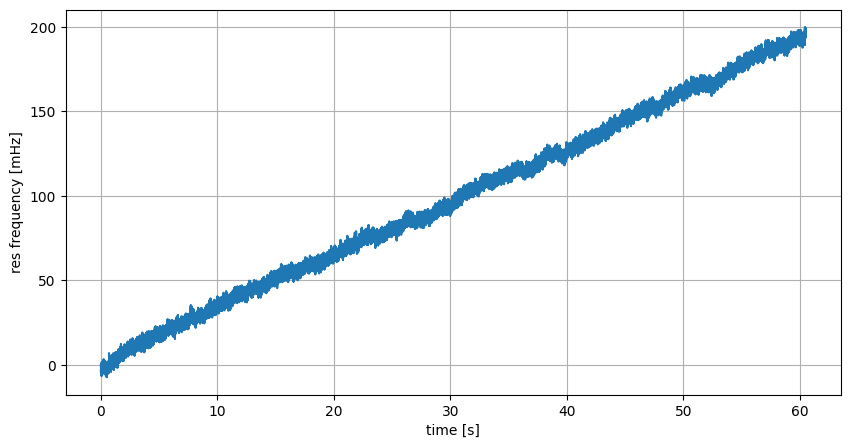

In [91]:
# constants
k_p = 174.5 * 1e-3 * 360  # prop gain
f_pll = k_p / 2 / np.pi # PLL bandwidth f

# dV/dm in units [V/m], amp_d_demod in units [V], noise_d in units [V^2/Hz], else SI
params = {'t_r':1.945, 'bw_pll':f_pll, "bw_dm":2.5e3, "m_e":3.56e-11, "dV_dm":1.49e6, 
          "f0_r":153.246e3, "noise_d":7.8e-15, "temp":300, "amp_d_rms":22e-3, "order_lp":4}

# load class
data = AnalysisPsd(**params)
data.load_timeseries(data_MFLI_fd - data_MFLI_fd[0], data_MFLI_t)

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(data.t, data.f_r*1e3)
plt.xlabel("time [s]")
plt.ylabel("res frequency [mHz]")

print("freq at t=0 [Hz]: ", data_MFLI_fd[0])
print("q factor [K]: ", int(data.qfactor*1e-3))
print("noise detection [fm/root-Hz]", np.sqrt(data.noise_d_m)*1e15)

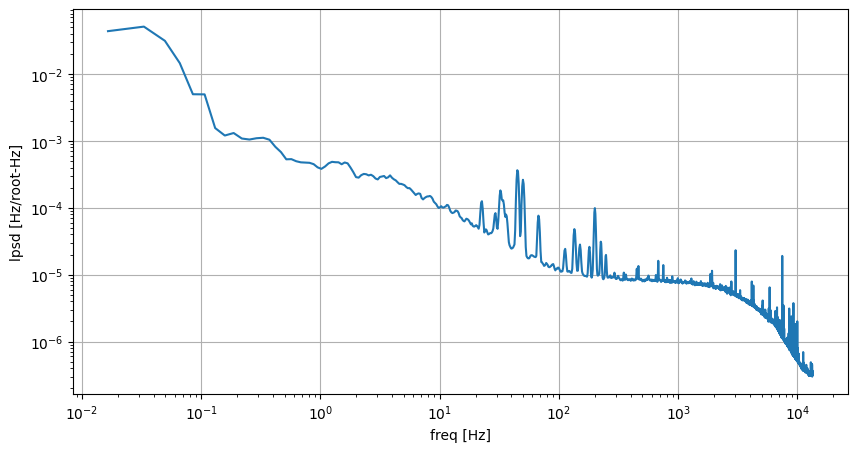

In [92]:
# calculate lpsd
data.get_lpsd()

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(data.s, np.sqrt(data.psd))
plt.xlabel("freq [Hz]")
plt.ylabel("lpsd [Hz/root-Hz]")
plt.xscale("log")
plt.yscale("log")

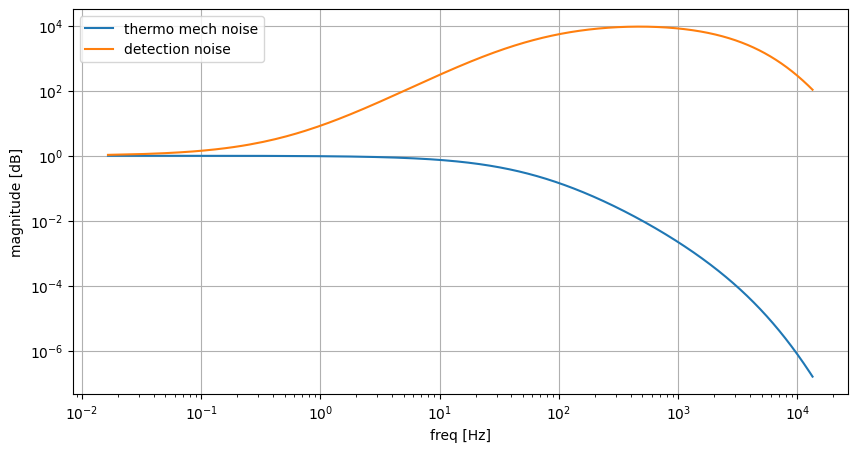

In [93]:
# noise transfer functions
data.get_tf_noise_thm()
data.get_tf_noise_d()

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(data.s, np.abs(data.tf_noise_thm)**2, label="thermo mech noise")
plt.plot(data.s, np.abs(data.tf_noise_d)**2, label="detection noise")
plt.xlabel("freq [Hz]")
plt.ylabel("magnitude [dB]")
plt.xscale("log")
plt.yscale("log")
plt.legend()

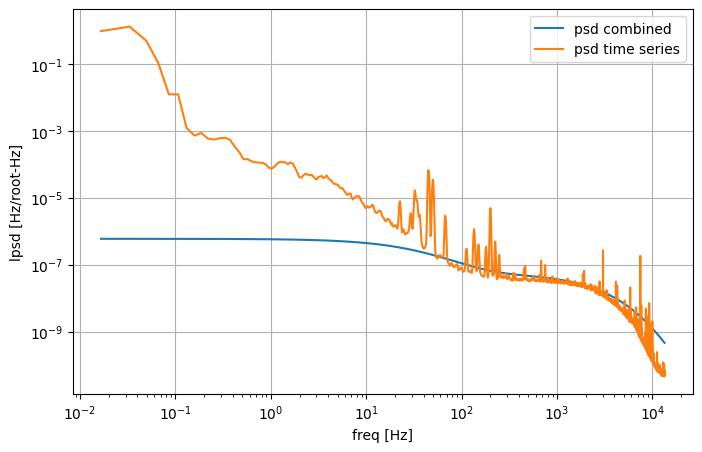

In [102]:
# psd noise
data.get_floor_noise_d()
data.get_floor_noise_thm()

data.get_psd_d()
data.get_psd_thm()

plt.figure(figsize=(8, 5))
plt.grid(True)
# plt.plot(data.s, data.psd_thm_noise, label="psd thm noise")
# plt.plot(data.s, data.psd_d_noise, label="psd d noise")
plt.plot(data.s, data.psd_thm_noise + data.psd_d_noise, label="psd combined")

plt.plot(data.s, data.psd * 5e2, label="psd time series")

plt.xlabel("freq [Hz]")
plt.ylabel("lpsd [Hz/root-Hz]")
plt.xscale("log")
plt.yscale("log")
plt.legend()